In [23]:
# import result data
import os
import csv

RESULT_PATH = "./results/"

In [119]:
### READ ALL PICKLES INTO DATAFRAME
import pandas as pd
import statistics
import pickle
import os


combined_peak_df = pd.DataFrame()
combined_nonpeak_df = pd.DataFrame()

for root, dirs, files in os.walk(RESULT_PATH):
    for i, file in enumerate(files):
        if file.endswith('.pkl') and "no-mycontent" not in root and "old" not in file:
            print(f"adding {file}\tfrom: {root}")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                if "nonpeak" in file_path:
                    print(f"adding {file} in nonpeak\n")
                    combined_nonpeak_df = pd.concat([combined_nonpeak_df,df], ignore_index=True)
                else:
                    print(f"adding {file} in peak\n")
                    combined_peak_df = pd.concat([combined_peak_df, df], ignore_index=True)

peak_count = len(combined_peak_df)
nonpeak_count= len(combined_nonpeak_df)
print(peak_count, nonpeak_count)

adding 0_combined_pickle.pkl	from: ./results/nonpeak-23-06-2023_00hh_24mm-TO-23-06-2023_06hh_47mm
adding 0_combined_pickle.pkl in nonpeak

adding 0_combined_pickle.pkl	from: ./results/nonpeak-24-06-2023_14hh_22mm-TO-24-06-2023_17hh_42mm
adding 0_combined_pickle.pkl in nonpeak

adding 0_combined_pickle.pkl	from: ./results/nonpeak-23-06-2023_18hh_33mm-TO-23-06-2023_19hh_19mm
adding 0_combined_pickle.pkl in nonpeak

adding 0_combined_pickle.pkl	from: ./results/weekend-peak-23-06-2023_19hh_46mm-TO-24-06-2023_01hh_47mm
adding 0_combined_pickle.pkl in peak

402402 711328


In [120]:
df = pd.concat([combined_nonpeak_df, combined_nonpeak_df])

pop_to_all_ips = {}
pop_to_ip = {}

cf_pop = df['X-Amz-Cf-Pop'].tolist()
cf_ip = df['responseIP'].tolist()
for pop, ip in zip(cf_pop, cf_ip):
    if pop in pop_to_all_ips:
        ips = pop_to_all_ips[pop]
        ips.append(ip)
        pop_to_all_ips[pop] = ips
    else:
        pop_to_all_ips[pop] = [ip]


for pop, ips in pop_to_all_ips.items():
    if pop not in pop_to_ip:
        ip = statistics.mode(ips)
        pop_to_ip[pop] = ip
        print (f"'{pop}' : '{ip}',")

'SFO5-M1' : '54.240.129.120',
'SFO20-M2' : '54.240.130.112',
'SFO50-M3' : '54.240.131.106',
'AMS51-M1' : '54.182.215.107',
'AMS53-M3' : '54.182.217.119',
'AMS52-M2' : '54.182.216.107',
'LHR62-M3' : '54.182.190.114',
'LHR61-M2' : '54.182.171.111',
'LHR50-M1' : '54.182.235.105',
'FRA52-M2' : '54.182.219.110',
'FRA54-M3' : '54.182.220.122',
'FRA51-M1' : '54.182.218.103',
' ' : ' ',
'ZRH55-P1' : '18.165.183.22',
'VIE50-P2' : '3.161.119.9',
'MXP64-C2' : '99.86.159.35',
'MXP63-P3' : '108.139.243.129',
'ZRH50-C1' : '13.224.103.49',
'VIE50-C2' : '2600:9000:211a:8000:e:4c8b:3c00:21',
'MXP64-C1' : '143.204.14.60',
'MXP64-P1' : '2600:9000:248c:6000:12:9d20:9180:21',
'VIE50-P1' : '2600:9000:2304:7a00:a:d8cc:cdc0:21',
'MXP63-P1' : '18.66.200.24',
'MXP53-P1' : '2600:9000:25e9:8800:14:6c65:4300:21',
'MXP64-P2' : '108.138.199.26',


AVERAGE LATENCY (PEAK):
overall: 36.814432683648334
top10: 8.477630219332507
popular: 30.570926053735906
nonpopular: 39.8224763091489
mycontent: 9.179923093509373
recentlyadded: 38.614551870848295


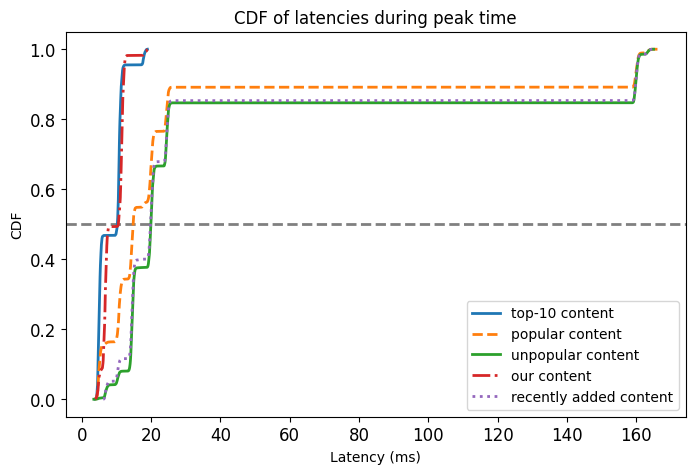

In [701]:
### LATENCY CDF DURING PEAK TIME
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import statsmodels.api as sm
pd.options.mode.chained_assignment = None

# filter content into dfs
df = combined_peak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]


# Calculate the CDF values
top10_df['latency(ms)'] = pd.to_numeric(top10_df['latency(ms)'], errors='coerce')
ecdf_top10 = sm.distributions.ECDF(top10_df['latency(ms)'])
x_top10 = sorted(top10_df['latency(ms)'].unique())
y_top10 = ecdf_top10(x_top10)

popular_df['latency(ms)'] = pd.to_numeric(popular_df['latency(ms)'], errors='coerce')
ecdf_popular = sm.distributions.ECDF(popular_df['latency(ms)'])
x_popular = sorted(popular_df['latency(ms)'].unique())
y_popular = ecdf_popular(x_popular)

nonpopular_df['latency(ms)'] = pd.to_numeric(nonpopular_df['latency(ms)'], errors='coerce')
ecdf_nonpopular = sm.distributions.ECDF(nonpopular_df['latency(ms)'])
x_nonpopular = sorted(nonpopular_df['latency(ms)'].unique())
y_nonpopular = ecdf_nonpopular(x_nonpopular)

mycontent_df['latency(ms)'] = pd.to_numeric(mycontent_df['latency(ms)'], errors='coerce')
ecdf_mycontent = sm.distributions.ECDF(mycontent_df['latency(ms)'])
x_mycontent = sorted(mycontent_df['latency(ms)'].unique())
y_mycontent = ecdf_mycontent(x_mycontent)

recentlyadded_df['latency(ms)'] = pd.to_numeric(recentlyadded_df['latency(ms)'], errors='coerce')
ecdf_recentlyadded = sm.distributions.ECDF(recentlyadded_df['latency(ms)'])
x_recentlyadded = sorted(recentlyadded_df['latency(ms)'].unique())
y_recentlyadded = ecdf_recentlyadded(x_recentlyadded)


# Set the figure size
plt.figure(figsize=(8, 5))

# Calculate the averages
average_top10 = top10_df['latency(ms)'].mean()
average_popular = popular_df['latency(ms)'].mean()
average_nonpopular = nonpopular_df['latency(ms)'].mean()
average_mycontent = mycontent_df['latency(ms)'].mean()
average_recentlyadded = recentlyadded_df['latency(ms)'].mean()
average_overall = df['latency(ms)'].mean()
print(f"AVERAGE LATENCY (PEAK):\noverall: {average_overall}\ntop10: {average_top10}\npopular: {average_popular}\nnonpopular: {average_nonpopular}\nmycontent: {average_mycontent}\nrecentlyadded: {average_recentlyadded}")

# Plot the median lines
plt.axhline(0.5, linestyle='--', color='grey')

# Set labels and title
plt.xlabel('Latency (ms)')
plt.ylabel('CDF')


plt.plot(x_top10, y_top10, linestyle='-', label='top-10 content')  # Solid line
plt.plot(x_popular, y_popular, linestyle='--', label='popular content')  # Dashed line
plt.plot(x_nonpopular, y_nonpopular, linestyle='-', label='unpopular content')  # Dotted line
plt.plot(x_mycontent, y_mycontent, linestyle='-.', label='our content')  # Dash-dot line
plt.plot(x_recentlyadded, y_recentlyadded, linestyle=':', label='recently added content')  # Solid line

# Increase line thickness (optional)
plt.setp(plt.gca().get_lines(), linewidth=2)

# Show the legend with adjusted font size
plt.legend(fontsize=12)

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot with higher resolution (optional)
plt.savefig('./figs/cdf_latencies_peak.png', dpi=300) 

# Set title
plt.title('CDF of latencies during peak time')

# Show the legend
plt.legend()

AVERAGE LATENCY (NON-PEAK):
overall: 45.07021963785114
top10: 6.584733396182521
popular: 36.408592703502094
nonpopular: 49.204588977621086
mycontent: 7.876407392805188
recentlyadded: 47.7947154307648


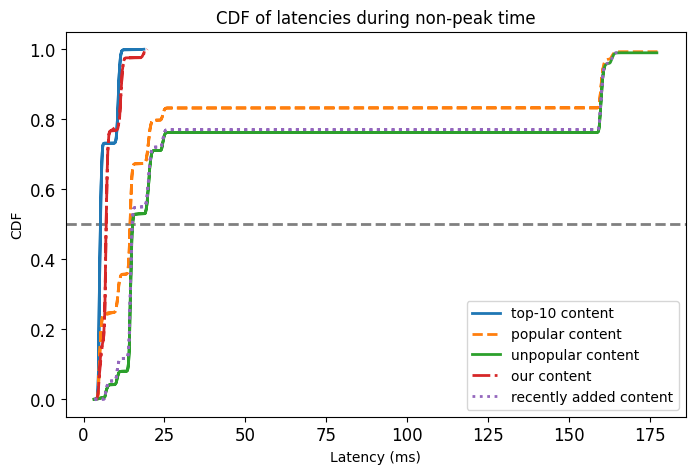

In [703]:
### LATENCY CDF DURING NON-PEAK TIME
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import statsmodels.api as sm
pd.options.mode.chained_assignment = None

# filter content into dfs
df = combined_nonpeak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]


# Calculate the CDF values
top10_df['latency(ms)'] = pd.to_numeric(top10_df['latency(ms)'], errors='coerce')
ecdf_top10 = sm.distributions.ECDF(top10_df['latency(ms)'])
x_top10 = sorted(top10_df['latency(ms)'].unique())
y_top10 = ecdf_top10(x_top10)

popular_df['latency(ms)'] = pd.to_numeric(popular_df['latency(ms)'], errors='coerce')
ecdf_popular = sm.distributions.ECDF(popular_df['latency(ms)'])
x_popular = sorted(popular_df['latency(ms)'].unique())
y_popular = ecdf_popular(x_popular)

nonpopular_df['latency(ms)'] = pd.to_numeric(nonpopular_df['latency(ms)'], errors='coerce')
ecdf_nonpopular = sm.distributions.ECDF(nonpopular_df['latency(ms)'])
x_nonpopular = sorted(nonpopular_df['latency(ms)'].unique())
y_nonpopular = ecdf_nonpopular(x_nonpopular)

mycontent_df['latency(ms)'] = pd.to_numeric(mycontent_df['latency(ms)'], errors='coerce')
ecdf_mycontent = sm.distributions.ECDF(mycontent_df['latency(ms)'])
x_mycontent = sorted(mycontent_df['latency(ms)'].unique())
y_mycontent = ecdf_mycontent(x_mycontent)

recentlyadded_df['latency(ms)'] = pd.to_numeric(recentlyadded_df['latency(ms)'], errors='coerce')
ecdf_recentlyadded = sm.distributions.ECDF(recentlyadded_df['latency(ms)'])
x_recentlyadded = sorted(recentlyadded_df['latency(ms)'].unique())
y_recentlyadded = ecdf_recentlyadded(x_recentlyadded)


# Set the figure size
plt.figure(figsize=(8, 5))

# Calculate the averages
average_top10 = top10_df['latency(ms)'].mean()
average_popular = popular_df['latency(ms)'].mean()
average_nonpopular = nonpopular_df['latency(ms)'].mean()
average_mycontent = mycontent_df['latency(ms)'].mean()
average_recentlyadded = recentlyadded_df['latency(ms)'].mean()
df['latency(ms)'] = pd.to_numeric(df['latency(ms)'], errors='coerce')
average_overall = df['latency(ms)'].mean()
print(f"AVERAGE LATENCY (NON-PEAK):\noverall: {average_overall}\ntop10: {average_top10}\npopular: {average_popular}\nnonpopular: {average_nonpopular}\nmycontent: {average_mycontent}\nrecentlyadded: {average_recentlyadded}")

# Plot the median lines
plt.axhline(0.5, linestyle='--', color='grey')

# Set labels and title
plt.xlabel('Latency (ms)')
plt.ylabel('CDF')


plt.plot(x_top10, y_top10, linestyle='-', label='top-10 content')  # Solid line
plt.plot(x_popular, y_popular, linestyle='--', label='popular content')  # Dashed line
plt.plot(x_nonpopular, y_nonpopular, linestyle='-', label='unpopular content')  # Dotted line
plt.plot(x_mycontent, y_mycontent, linestyle='-.', label='our content')  # Dash-dot line
plt.plot(x_recentlyadded, y_recentlyadded, linestyle=':', label='recently added content')  # Solid line


# Increase line thickness (optional)
plt.setp(plt.gca().get_lines(), linewidth=2)

# Show the legend with adjusted font size
plt.legend(fontsize=12)

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot with higher resolution (optional)
plt.savefig('./figs/cdf_latencies_nonpeak.png', dpi=300) 

# Set title
plt.title('CDF of latencies during non-peak time')

# Show the legend
plt.legend()

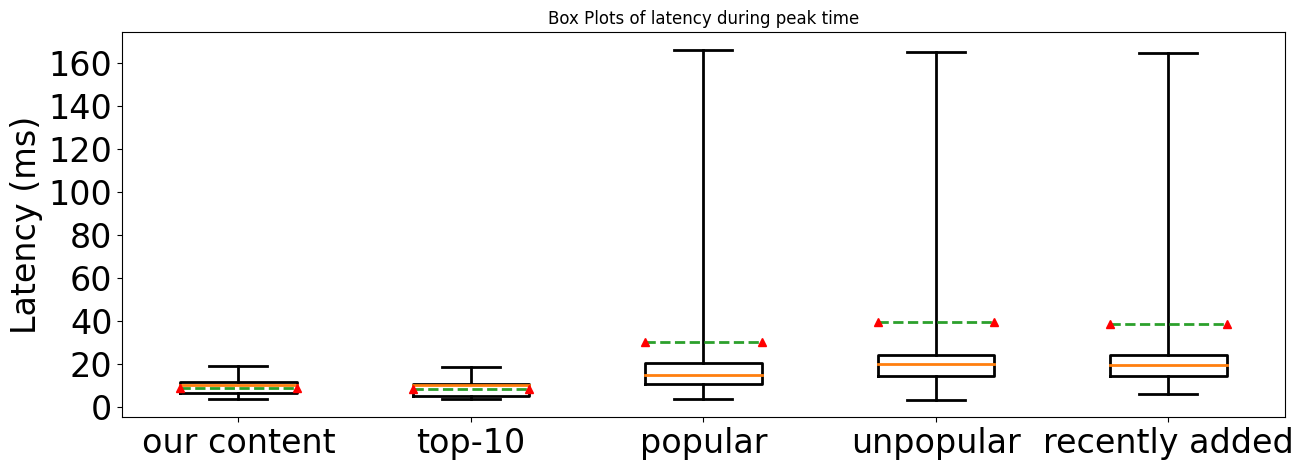

In [585]:
### BOXPLOT OF LATENCIES DURING PEAK-TIME
import matplotlib.pyplot as plt

# filter content into dfs
df = combined_peak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]

# Create a list of latency values for each DataFrame
latency_data = [
    mycontent_df['latency(ms)'],
    top10_df['latency(ms)'],
    popular_df['latency(ms)'],
    nonpopular_df['latency(ms)'],
    recentlyadded_df['latency(ms)']
]

# Set the figure size
plt.figure(figsize=(15, 5))

# Create the box plots
plt.boxplot(latency_data, showfliers=True, whis=100, meanline=True, showmeans=True, meanprops={'marker':'^', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Set x-axis tick labels
labels = ['our content', 'top-10', 'popular', 'unpopular', 'recently added']
plt.xticks(range(1, len(labels) + 1), labels)

# Set labels and title
#plt.xlabel('Dataframes')
plt.ylabel('Latency (ms)', fontsize=24)

# Increase line thickness (optional)
plt.setp(plt.gca().get_lines(), linewidth=2)

# Adjust tick label font size
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Save the plot with higher resolution (optional)
plt.savefig('./figs/boxplot_latencies_peak.png', dpi=300) 

# Set title
plt.title('Box Plots of latency during peak time')

# Show the plot
plt.show()


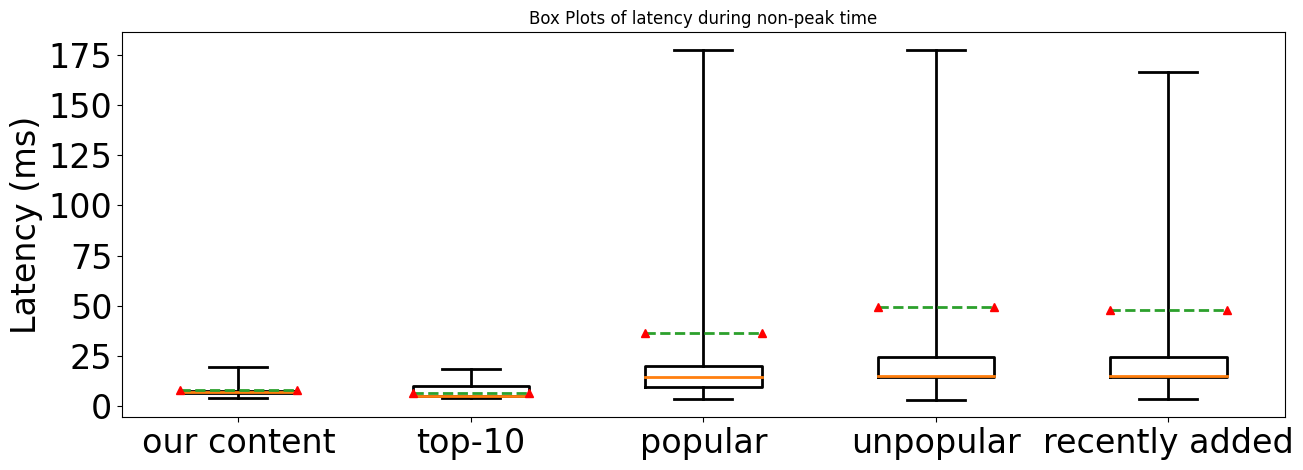

In [584]:
### BOXPLOT OF LATENCIES DURING NON-PEAK-TIME
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

# filter content into dfs
df = combined_nonpeak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]

top10_df['latency(ms)'] = pd.to_numeric(top10_df['latency(ms)'], errors='coerce')
top10_df.dropna(subset=['latency(ms)'], inplace=True)

popular_df['latency(ms)'] = pd.to_numeric(popular_df['latency(ms)'], errors='coerce')
popular_df.dropna(subset=['latency(ms)'], inplace=True)

nonpopular_df['latency(ms)'] = pd.to_numeric(nonpopular_df['latency(ms)'], errors='coerce')
nonpopular_df.dropna(subset=['latency(ms)'], inplace=True)

mycontent_df['latency(ms)'] = pd.to_numeric(mycontent_df['latency(ms)'], errors='coerce')
mycontent_df.dropna(subset=['latency(ms)'], inplace=True)

recentlyadded_df['latency(ms)'] = pd.to_numeric(recentlyadded_df['latency(ms)'], errors='coerce')
recentlyadded_df.dropna(subset=['latency(ms)'], inplace=True)

# Create a list of latency values for each DataFrame
latency_data = [
    mycontent_df['latency(ms)'],
    top10_df['latency(ms)'],
    popular_df['latency(ms)'],
    nonpopular_df['latency(ms)'],
    recentlyadded_df['latency(ms)']
]

# Set the figure size
plt.figure(figsize=(15, 5))

# Create the box plots
plt.boxplot(latency_data, showfliers=True, whis=100, meanline=True, showmeans=True, meanprops={'marker':'^', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Set x-axis tick labels
labels = ['our content', 'top-10', 'popular', 'unpopular', 'recently added']
plt.xticks(range(1, len(labels) + 1), labels)

# Set labels and title
#plt.xlabel('Dataframes')
plt.ylabel('Latency (ms)', fontsize=24)

# Increase line thickness (optional)
plt.setp(plt.gca().get_lines(), linewidth=2)

# Adjust tick label font size
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Save the plot with higher resolution (optional)
plt.savefig('./figs/boxplot_latencies_nonpeak.png', dpi=300) 

# Set title
plt.title('Box Plots of latency during non-peak time')

# Show the plot
plt.show()


*** AVG EDGE LATENCIES ***
VIE 17.96
SFO 160.46
MXP 10.92
ZRH 5.1
FRA 14.52
LHR 20.1
AMS 24.59


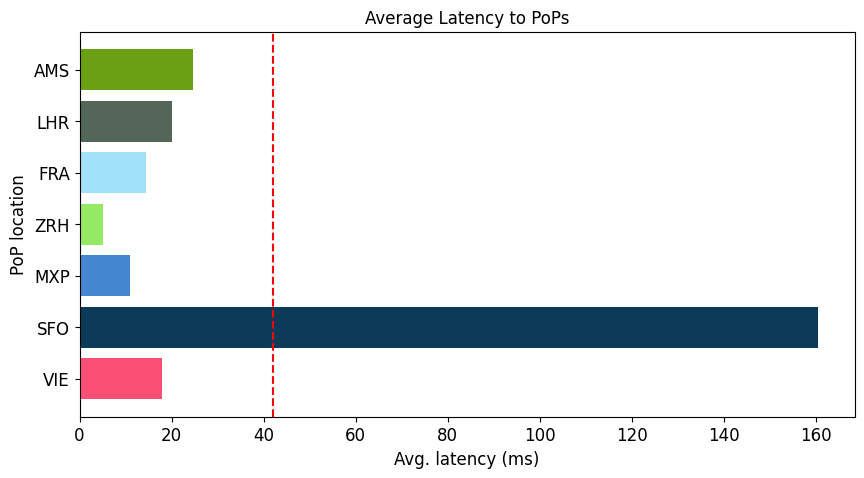

In [586]:
import matplotlib.pyplot as plt
import numpy as np

# filter content into dfs
df = pd.concat([combined_peak_df, combined_nonpeak_df])

pops = df['X-Amz-Cf-Pop'].unique()
pops = set([pop[:3] for pop in pops])

edge_cities = []
latencies = []

print("*** AVG EDGE LATENCIES ***")
for pop in pops:
    pop = pop[:3]
    current_df = df[df['X-Amz-Cf-Pop'].str.contains(pop)]
    current_df['latency(ms)'] = pd.to_numeric(current_df['latency(ms)'], errors='coerce')
    mean_latency = round(current_df['latency(ms)'].mean(), 2)
    if pop != " ":
        print(pop, round(mean_latency, 2))
        edge_cities.append(pop)
        latencies.append(mean_latency)

# Overall average of all latencies
df['latency(ms)'] = pd.to_numeric(df['latency(ms)'], errors='coerce')
overall_average = round(df['latency(ms)'].mean(), 2)

# Generate random colors for the bars
colors = np.random.rand(len(edge_cities), 3)

# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the horizontal bar chart
plt.barh(edge_cities, latencies, color=colors)
plt.axvline(x=overall_average, color='r', linestyle='--', label='Overall Average')

# Set labels and title
plt.xlabel('Avg. latency (ms)', fontsize=12)
plt.ylabel('PoP location', fontsize=12)


# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot with higher resolution (optional)
plt.savefig('./figs/pops_avg_latencies.png', dpi=300) 

# Set title
plt.title('Average Latency to PoPs')


# Show the plot
plt.show()


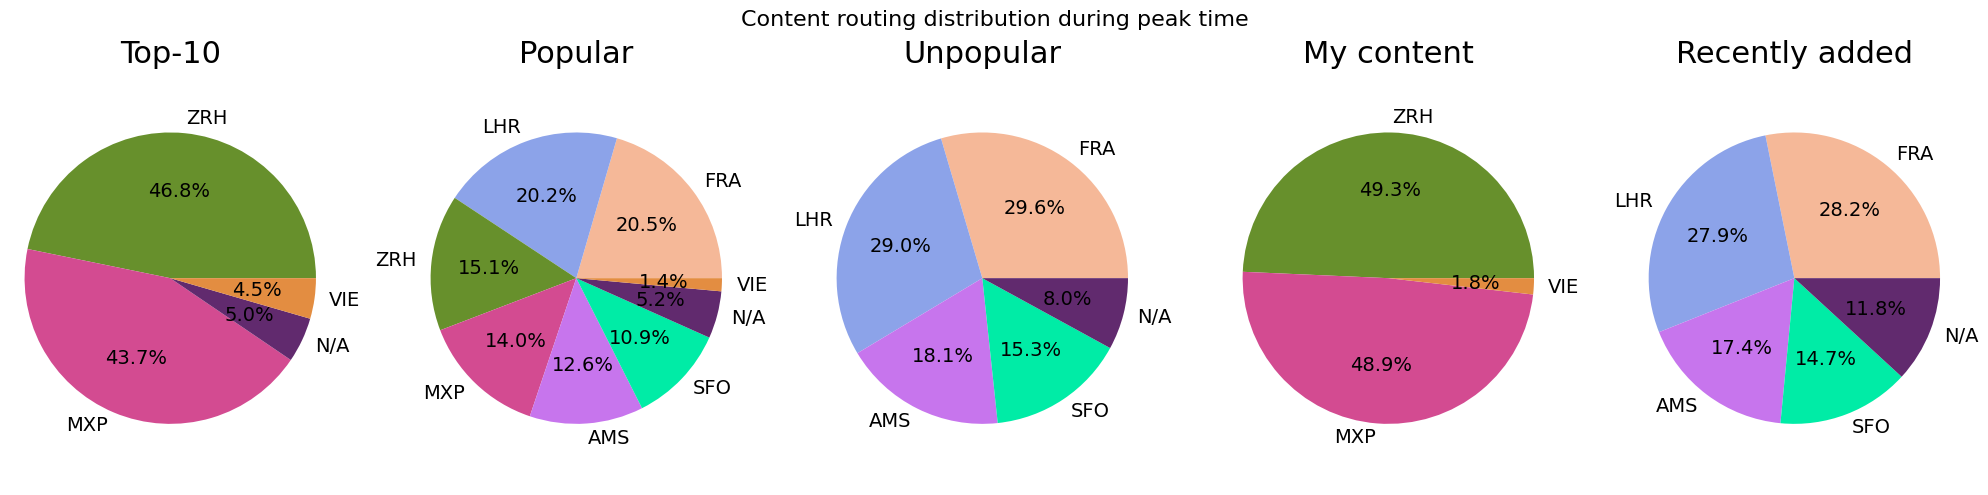

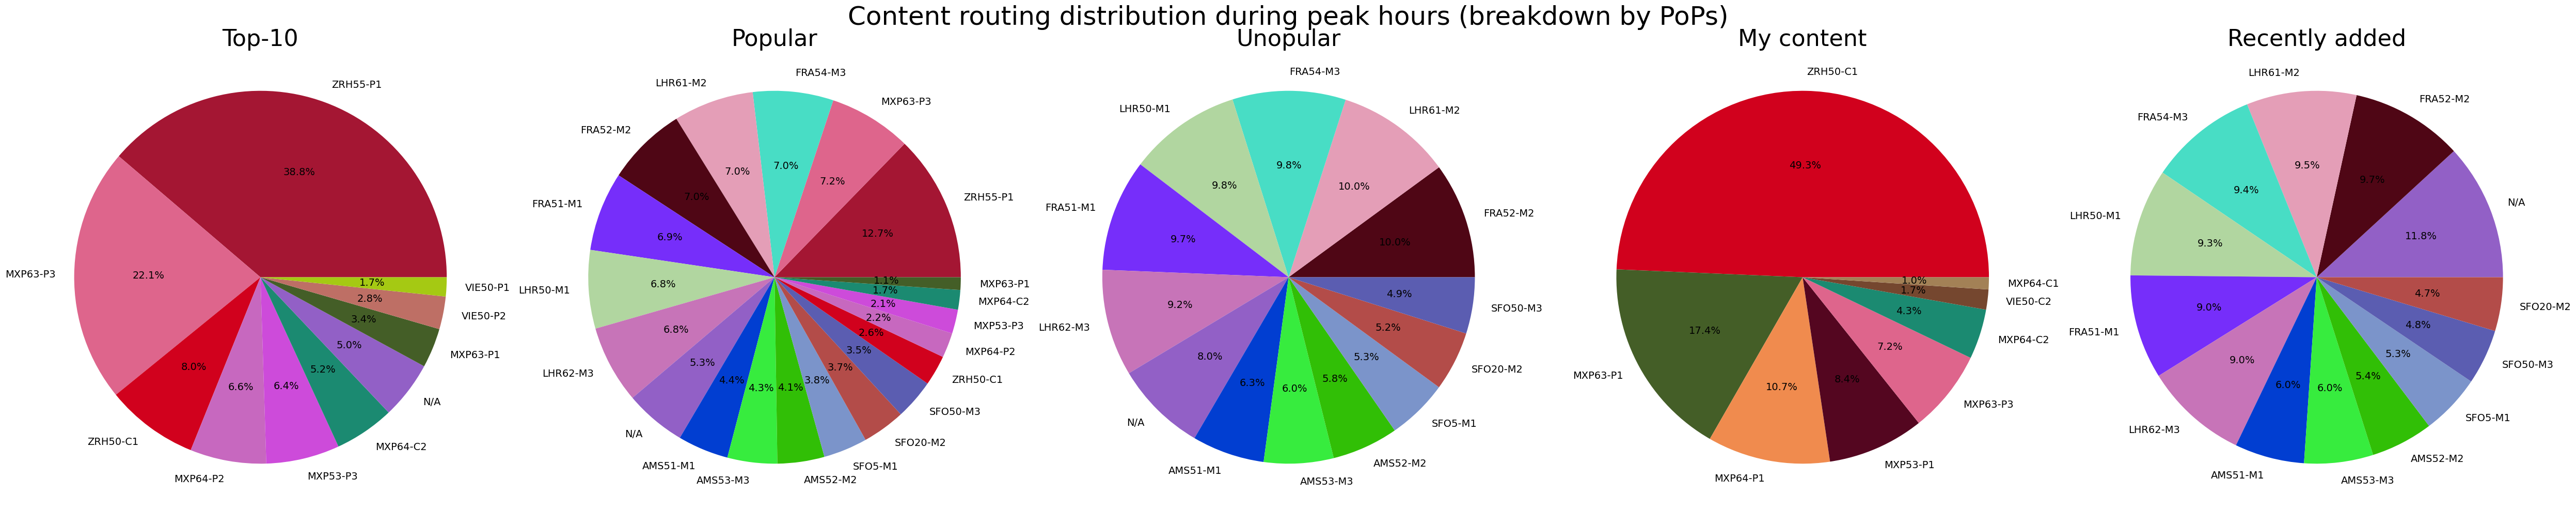

In [688]:
### ROUTING TO EDGE/POP DISTRIBUTION DURING PEAK TIME
import matplotlib.pyplot as plt

# filter content into dfs
df = combined_peak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]

dfs = [top10_df, popular_df, nonpopular_df, mycontent_df, recentlyadded_df]
titles = ["Top-10", "Popular", "Unpopular", "My content", "Recently added"]
# Create a figure with 1 row and 5 columns of subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Create a set of unique cities across all DataFrames
all_cities = set()
for df in dfs:
    df['X-Amz-Cf-Pop'] = df['X-Amz-Cf-Pop'].str[:3]
    df['X-Amz-Cf-Pop'] = df['X-Amz-Cf-Pop'].str.replace(" ", "N/A")
    all_cities.update(df['X-Amz-Cf-Pop'].unique())
import random

# Assign random colors to each city
color_mapping = {}
for city in all_cities:
    color_mapping[city] = '#' + '%06x' % random.randint(90, 0xFFFFFF)  # Generate a random color hex code

# Iterate over the DataFrames and plot the pie charts
for i, df in enumerate(dfs):
    city_counts = df['X-Amz-Cf-Pop'].value_counts()
    city_percentages = city_counts / len(df) * 100
    city_percentages = city_percentages[city_percentages >= 0.1]
    cities = city_percentages.index.tolist()
    colors = [color_mapping[city] for city in cities]  
    axs[i].pie(city_percentages, labels=city_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=colors)
    axs[i].set_title(f'{titles[i]}', fontsize=22)
    axs[i].axis('equal')

# Adjust the spacing between subplots and legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot with higher resolution (optional)
plt.savefig('./figs/pie_routing_peak.png', dpi=300) 

# Add a title on top
fig.suptitle('Content routing distribution during peak time', fontsize=16)

# Show the plot
plt.show()


### PIE-CHART WITH FURTHER BREAKDOWN
df = combined_peak_df
top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]

# Create list of dfs for pie charts
dfs = [top10_df, popular_df, nonpopular_df, mycontent_df, recentlyadded_df]
titles = ["Top-10", "Popular", "Unopular", "My content", "Recently added"]

# Create a set of unique cities across all DataFrames
all_cities = set()
for df in dfs:
    df['X-Amz-Cf-Pop'] = df['X-Amz-Cf-Pop'].str.replace(" ", "N/A")
    all_cities.update(df['X-Amz-Cf-Pop'].unique())
import random

# Assign random colors to each city
color_mapping = {}
for city in all_cities:
    color_mapping[city] = '#' + '%06x' % random.randint(90, 0xFFFFFF)  # Generate a random color hex code

# Create a figure with 1 row and 5 columns of subplots
fig, axs = plt.subplots(1, 5, figsize=(50, 10))

# Iterate over the DataFrames and plot the pie charts
for i, df in enumerate(dfs):
    city_counts = df['X-Amz-Cf-Pop'].value_counts()
    city_percentages = city_counts / len(df) * 100
    
    cities = city_percentages.index.tolist()
    colors = [color_mapping[city] for city in cities]  
    
    city_percentages = city_percentages[city_percentages >= 1]
    axs[i].pie(city_percentages, labels=city_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=colors)
    axs[i].set_title(f'{titles[i]}', fontsize=32)
    axs[i].axis('equal')

# Adjust the spacing between subplots and legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot with higher resolution (optional)
plt.savefig('./figs/pie_routing_peak_detailed.png', dpi=300) 

# Add a title on top
fig.suptitle('Content routing distribution during peak hours (breakdown by PoPs)', fontsize=36)

# Show the plot
plt.show()

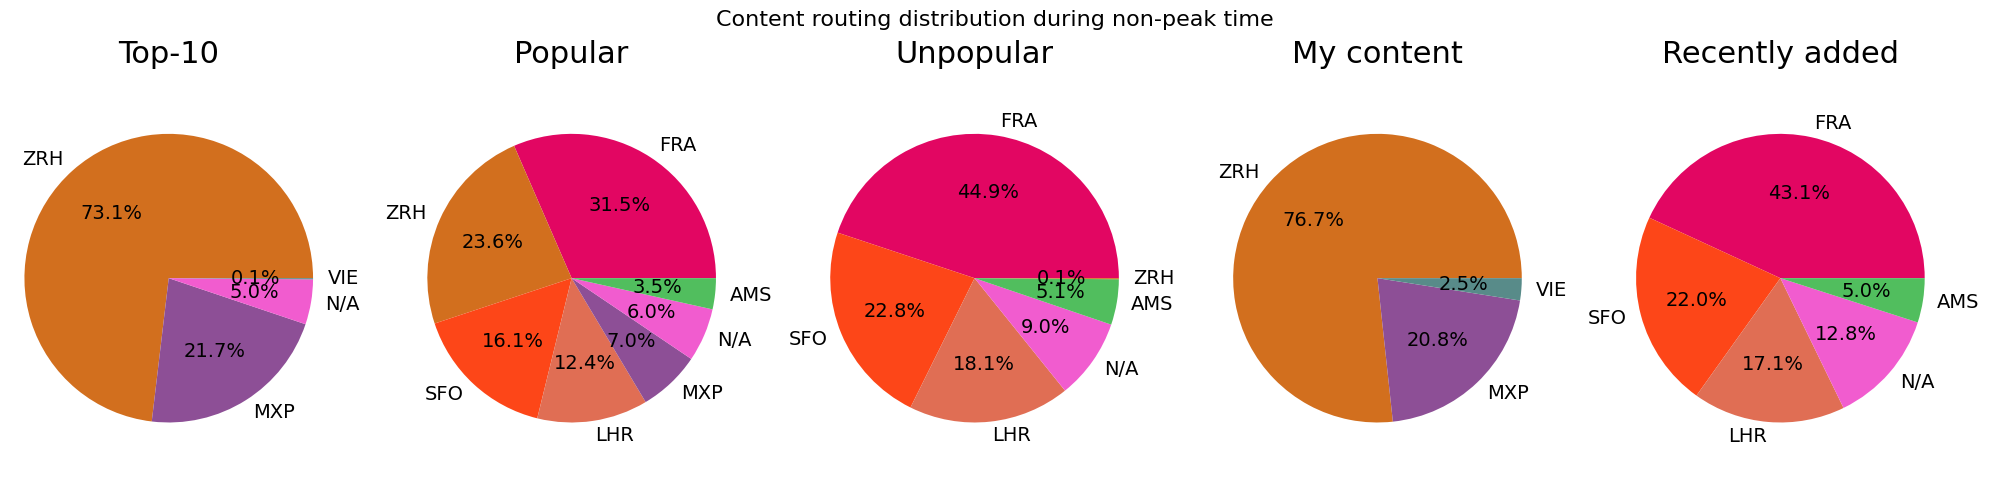

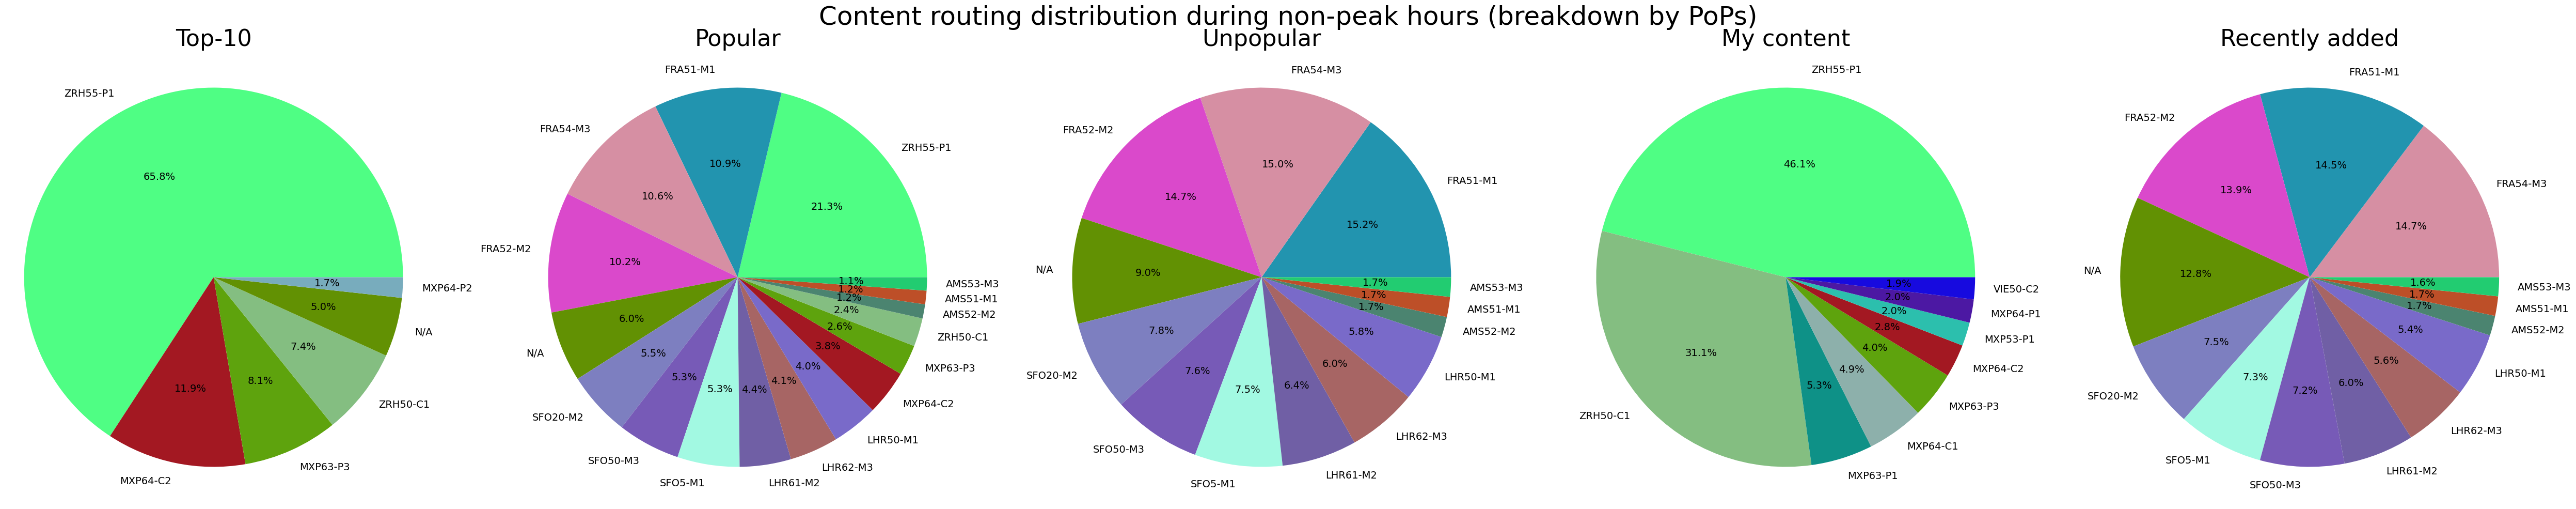

In [685]:
### ROUTING TO EDGE/POP DISTRIBUTION DURING NON-PEAK TIME
import matplotlib.pyplot as plt

# filter content into dfs
df = combined_nonpeak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]

dfs = [top10_df, popular_df, nonpopular_df, mycontent_df, recentlyadded_df]
titles = ["Top-10", "Popular", "Unpopular", "My content", "Recently added"]
# Create a figure with 1 row and 5 columns of subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Create a set of unique cities across all DataFrames
all_cities = set()
for df in dfs:
    df['X-Amz-Cf-Pop'] = df['X-Amz-Cf-Pop'].str[:3]
    df['X-Amz-Cf-Pop'] = df['X-Amz-Cf-Pop'].str.replace(" ", "N/A")
    all_cities.update(df['X-Amz-Cf-Pop'].unique())
import random

# Assign random colors to each city
color_mapping = {}
for city in all_cities:
    color_mapping[city] = '#' + '%06x' % random.randint(90, 0xFFFFFF)  # Generate a random color hex code

# Iterate over the DataFrames and plot the pie charts
for i, df in enumerate(dfs):
    city_counts = df['X-Amz-Cf-Pop'].value_counts()
    city_percentages = city_counts / len(df) * 100
    city_percentages = city_percentages[city_percentages >= 0.1]
    cities = city_percentages.index.tolist()
    colors = [color_mapping[city] for city in cities]  
    axs[i].pie(city_percentages, labels=city_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=colors)
    axs[i].set_title(f'{titles[i]}', fontsize=22)
    axs[i].axis('equal')

# Adjust the spacing between subplots and legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot with higher resolution (optional)
plt.savefig('./figs/pie_routing_nonpeak.png', dpi=300) 

# Add a title on top
fig.suptitle('Content routing distribution during non-peak time', fontsize=16)

# Show the plot
plt.show()


### PIE-CHART WITH FURTHER BREAKDOWN
df = combined_nonpeak_df
top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]

# Create list of dfs for pie charts
dfs = [top10_df, popular_df, nonpopular_df, mycontent_df, recentlyadded_df]
titles = ["Top-10", "Popular", "Unpopular", "My content", "Recently added"]

# Create a set of unique cities across all DataFrames
all_cities = set()
for df in dfs:
    df['X-Amz-Cf-Pop'] = df['X-Amz-Cf-Pop'].str.replace(" ", "N/A")
    all_cities.update(df['X-Amz-Cf-Pop'].unique())
import random

# Assign random colors to each city
color_mapping = {}
for city in all_cities:
    color_mapping[city] = '#' + '%06x' % random.randint(90, 0xFFFFFF)  # Generate a random color hex code

# Create a figure with 1 row and 5 columns of subplots
fig, axs = plt.subplots(1, 5, figsize=(50, 10))

# Iterate over the DataFrames and plot the pie charts
for i, df in enumerate(dfs):
    city_counts = df['X-Amz-Cf-Pop'].value_counts()
    city_percentages = city_counts / len(df) * 100
    
    cities = city_percentages.index.tolist()
    colors = [color_mapping[city] for city in cities]  
    
    city_percentages = city_percentages[city_percentages >= 1]
    axs[i].pie(city_percentages, labels=city_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=colors)
    axs[i].set_title(f'{titles[i]}', fontsize=32)
    axs[i].axis('equal')

# Adjust the spacing between subplots and legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot with higher resolution (optional)
plt.savefig('./figs/pie_routing_nonpeak_detailed.png', dpi=300) 

# Add a title on top
fig.suptitle('Content routing distribution during non-peak hours (breakdown by PoPs)', fontsize=36)

# Show the plot
plt.show()

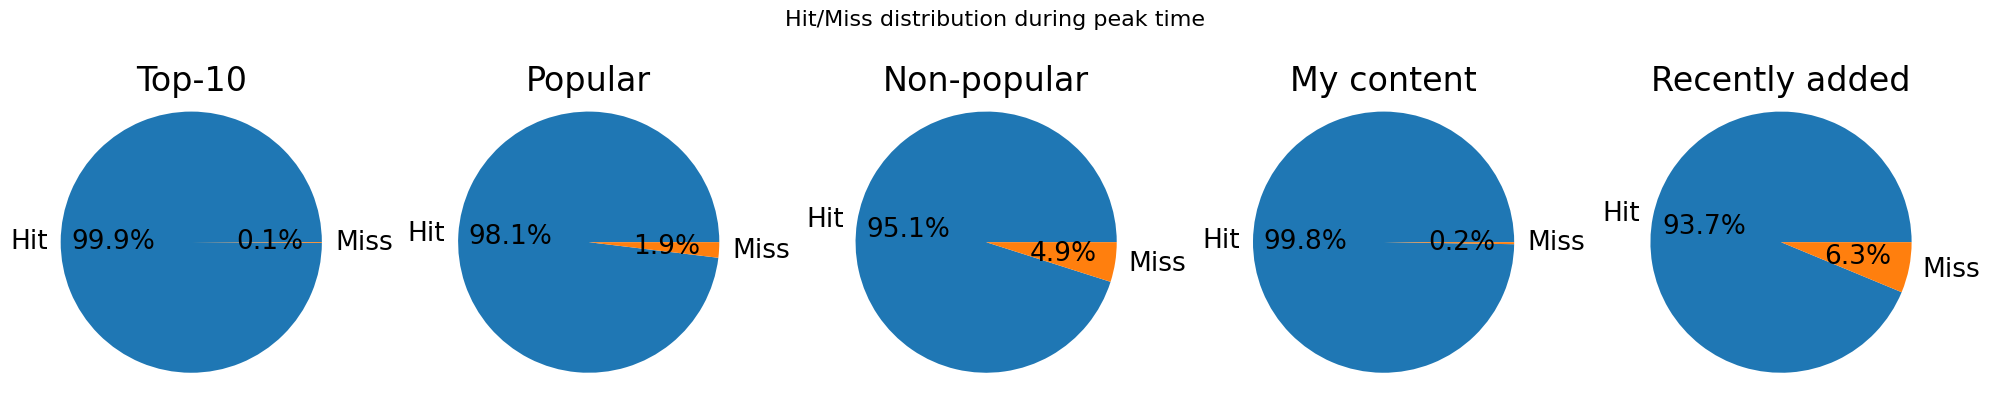

In [671]:
### HIT/MISS DISTRIBUTION DURING PEAK TIME
import matplotlib.pyplot as plt

# filter content into dfs
df = combined_peak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]


dfs = [top10_df, popular_df, nonpopular_df, mycontent_df, recentlyadded_df]
titles = ["Top-10", "Popular", "Non-popular", "My content", "Recently added"]
# Create a figure with 1 row and 5 columns of subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3, hspace=5)

# Iterate over the DataFrames and plot the pie charts
for i, df in enumerate(dfs):
    df['X-Cache'] = df['X-Cache'].str.replace(r'^\s*$', 'N/A', regex=True) # replace empty strings with N/A
    df['X-Cache'] = df['X-Cache'].str.replace('from cloudfront', '')
    df.loc[df['Age'] == " ", 'X-Cache'] = 'Miss' # if Age is empty, we consider it as a miss
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df.loc[df['Age'] > 0, 'X-Cache'] = 'Hit' # if Age > 0, we consider it as HIT
    hit_miss_counts = df['X-Cache'].value_counts()
    hit_miss_percentages = hit_miss_counts / len(df) * 100
    hit_miss_percentages = hit_miss_percentages[hit_miss_percentages >= 0.01]
    axs[i].pie(hit_miss_percentages, labels=hit_miss_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 19})
    axs[i].set_title(f'{titles[i]}', fontsize = 24)
    axs[i].axis('equal')

# Adjust the spacing between subplots and legend
plt.tight_layout(rect=[0, 0.2, 1, 0.90])

# Save the plot with higher resolution (optional)
plt.savefig('./figs/hit_miss_content_peak.png', dpi=300) 

# Add a title on top
fig.suptitle('Hit/Miss distribution during peak time', fontsize=16)

# Show the plot
plt.show()

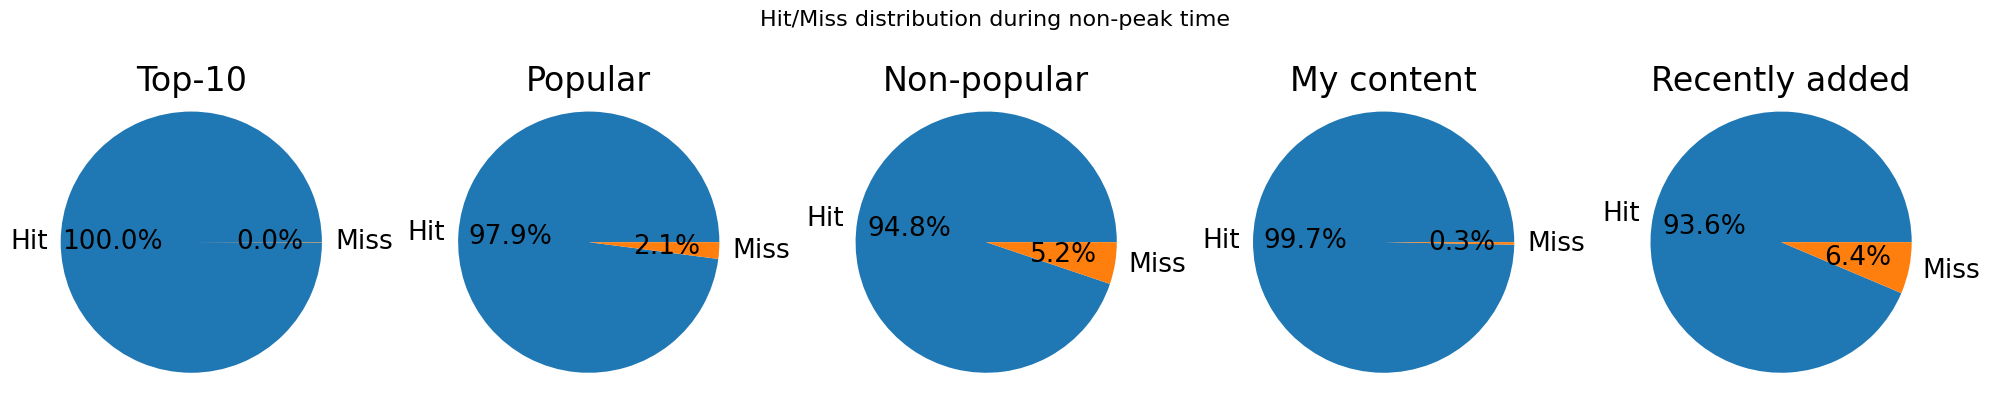

In [660]:
### HIT/MISS DISTRIBUTION DURING NON-PEAK TIME
import matplotlib.pyplot as plt

# filter content into dfs
df = combined_nonpeak_df
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies.csv"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv.csv"
        top_content_list.append(line)

top10_df = df[df['content'].isin(top_content_list)]
popular_df = df[df['content'].str.contains('_top_')]
popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
nonpopular_df = df[~df['content'].str.contains('_top_|myvideo|_recentlyadded_')]
mycontent_df = df[df['content'].str.contains('myvideo')]
recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]


dfs = [top10_df, popular_df, nonpopular_df, mycontent_df, recentlyadded_df]
titles = ["Top-10", "Popular", "Non-popular", "My content", "Recently added"]
# Create a figure with 1 row and 5 columns of subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3, hspace=5)

# Iterate over the DataFrames and plot the pie charts
for i, df in enumerate(dfs):
    df['X-Cache'] = df['X-Cache'].str.replace(r'^\s*$', 'N/A', regex=True) # replace empty strings with N/A
    df['X-Cache'] = df['X-Cache'].str.replace('from cloudfront', '')
    df.loc[df['Age'] == " ", 'X-Cache'] = 'Miss' # if Age is empty, we consider it as a miss
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df.loc[df['Age'] > 0, 'X-Cache'] = 'Hit' # if Age > 0, we consider it as HIT
    hit_miss_counts = df['X-Cache'].value_counts()
    hit_miss_percentages = hit_miss_counts / len(df) * 100
    hit_miss_percentages = hit_miss_percentages[hit_miss_percentages >= 0.01]
    axs[i].pie(hit_miss_percentages, labels=hit_miss_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 19})
    axs[i].set_title(f'{titles[i]}', fontsize = 24)
    axs[i].axis('equal')

# Adjust the spacing between subplots and legend
plt.tight_layout(rect=[0, 0.2, 1, 0.90])

# Save the plot with higher resolution (optional)
plt.savefig('./figs/hit_miss_content_nonpeak.png', dpi=300) 

# Add a title on top
fig.suptitle('Hit/Miss distribution during non-peak time', fontsize=16)

# Show the plot
plt.show()

adding 0_combined_pickle.pkl	from: ./results/nonpeak-23-06-2023_00hh_24mm-TO-23-06-2023_06hh_47mm
adding 0_combined_pickle.pkl in nonpeak

adding 0_combined_pickle.pkl	from: ./results/nonpeak-24-06-2023_14hh_22mm-TO-24-06-2023_17hh_42mm
adding 0_combined_pickle.pkl in nonpeak

adding 0_combined_pickle.pkl	from: ./results/nonpeak-23-06-2023_18hh_33mm-TO-23-06-2023_19hh_19mm
adding 0_combined_pickle.pkl in nonpeak

adding 0_combined_pickle.pkl	from: ./results/weekend-peak-23-06-2023_19hh_46mm-TO-24-06-2023_01hh_47mm
adding 0_combined_pickle.pkl in peak

402402 711328


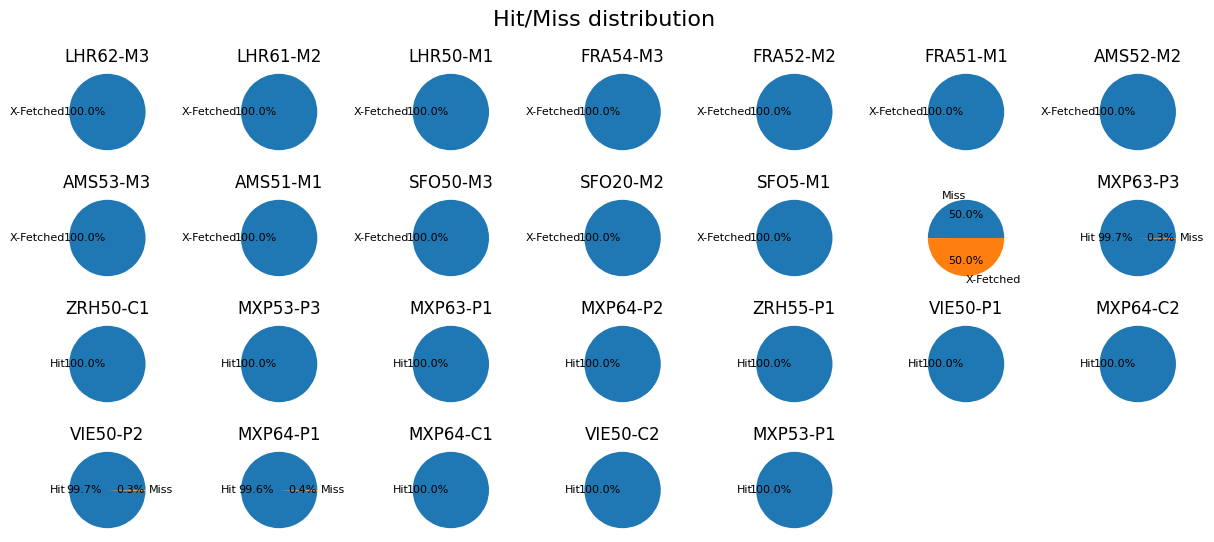

In [446]:
### HIT/MISS/FETCH-FROM-X-SERVER DISTRIBUTION OF EDGES
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import pickle
import os


combined_peak_df = pd.DataFrame()
combined_nonpeak_df = pd.DataFrame()

for root, dirs, files in os.walk(RESULT_PATH):
    for i, file in enumerate(files):
        if file.endswith('.pkl') and "no-mycontent" not in root and "old" not in file:
            print(f"adding {file}\tfrom: {root}")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                if "nonpeak" in file_path:
                    print(f"adding {file} in nonpeak\n")
                    combined_nonpeak_df = pd.concat([combined_nonpeak_df,df], ignore_index=True)
                else:
                    print(f"adding {file} in peak\n")
                    combined_peak_df = pd.concat([combined_peak_df, df], ignore_index=True)

peak_count = len(combined_peak_df)
nonpeak_count= len(combined_nonpeak_df)
print(peak_count, nonpeak_count)


# filter content into dfs
original_df = pd.concat([combined_peak_df, combined_nonpeak_df])
pops = df['X-Amz-Cf-Pop'].unique()

num_rows = 4  # Change the number of rows here
num_cols = int(np.ceil(len(pops) / num_rows))

titles = pops
# Create a figure with multiple rows and columns of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

for i, pop in enumerate(pops):
    df = original_df[original_df['X-Amz-Cf-Pop'] == pop]
    df['X-Cache'] = df['X-Cache'].str.replace(r'^\s*$', 'N/A', regex=True)
    df['X-Cache'] = df['X-Cache'].str.replace('from cloudfront', '')
    df.loc[df['Age'] == " ", 'X-Cache'] = 'Miss'
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df.loc[df['Age'] > 0, 'X-Cache'] = 'Hit'
    df.loc[df['X-Server-IP'] != " ", 'X-Cache'] = 'X-Fetched'
    hit_miss_counts = df['X-Cache'].value_counts()
    hit_miss_percentages = hit_miss_counts / len(df) * 100
    hit_miss_percentages = hit_miss_percentages[hit_miss_percentages >= 0.1]
    axs[i].pie(hit_miss_percentages, labels=hit_miss_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 8})
    axs[i].set_title(f'{titles[i]}')
    axs[i].axis('equal')

# Remove any unused subplots
if len(pops) < num_rows * num_cols:
    for j in range(len(pops), num_rows * num_cols):
        axs[j].axis('off')

# Add a title on top
fig.suptitle('Hit/Miss distribution', fontsize=16)

# Show the plot
plt.show()



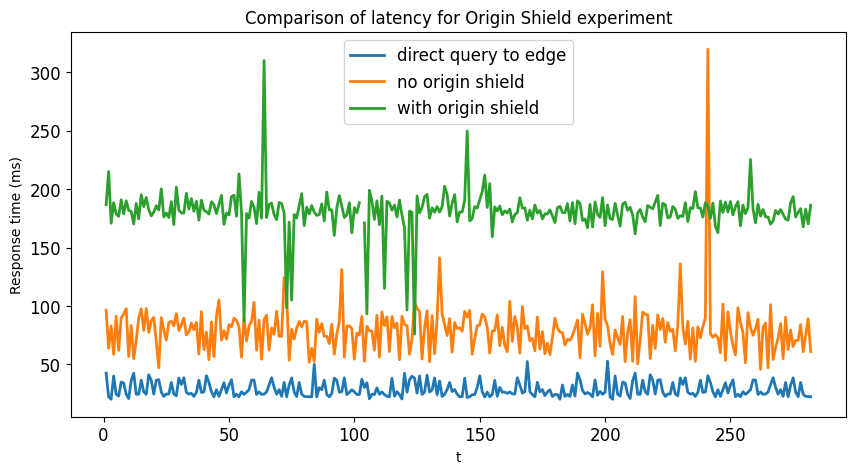

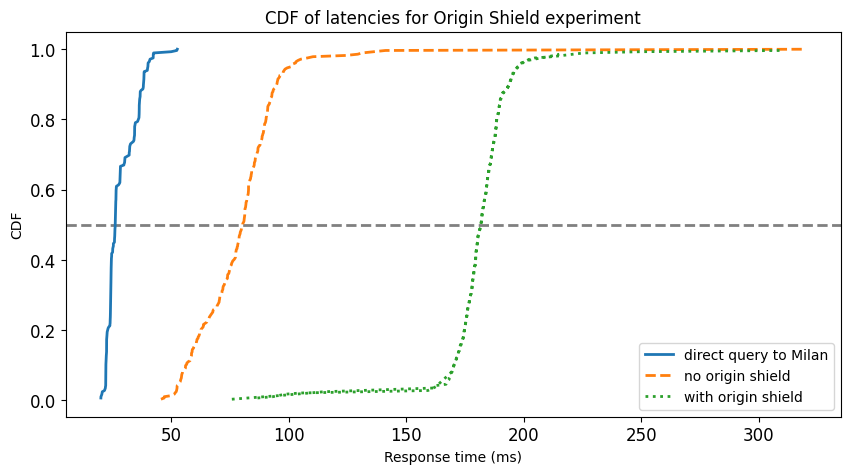

In [567]:
### ORIGIN SHIELD EXPERIMENT
RESULT_ORIGSHIELD_PATH = "./origin-shield-experiment-22-06-2023_22hh_43mm/"

# Load data into dfs
for root, dirs, files in os.walk(RESULT_ORIGSHIELD_PATH):
        # root: Current directory being scanned
        # dirs: Directories inside the current directory
        # files: Files inside the current directory
        no_origshield_df = pd.DataFrame()
        with_origshield_df = pd.DataFrame()
        direcyquery_df = pd.DataFrame()
        for i, file in enumerate(files):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            if "query_to_milan" in file and ".csv" in file:
                direcyquery_df = df
                #print(f"adding {file} in directquery_df")
            elif "no_originshield" in file and ".csv" in file:
                no_origshield_df = df
                #print(f"adding {file} in no_origshield_df")
            elif "myvideo_originshield" in file and ".csv" in file:
                 with_origshield_df = df
                 #print(f"adding {file} in with_origshield_df")


direcyquery_df['latency(ms)'] = pd.to_numeric(direcyquery_df['latency(ms)'], errors='coerce')
no_origshield_df['latency(ms)'] = pd.to_numeric(no_origshield_df['latency(ms)'], errors='coerce')
with_origshield_df['latency(ms)'] = pd.to_numeric(with_origshield_df['latency(ms)'], errors='coerce')

# X-axis values
x_direcyquery_df = range(1, len(direcyquery_df) + 1)
x_no_origshield_df = range(1, len(no_origshield_df) + 1)
x_with_origshield_df = range(1, len(with_origshield_df) + 1)

# Set the figure size
plt.figure(figsize=(10, 5))

# Plotting
plt.plot(x_direcyquery_df, direcyquery_df['latency(ms)'], label='direct query to edge')
plt.plot(x_no_origshield_df, no_origshield_df['latency(ms)'], label='no origin shield')
plt.plot(x_with_origshield_df, with_origshield_df['latency(ms)'], label='with origin shield')

# Set labels and title
plt.xlabel('t')
plt.ylabel('Response time (ms)')

# Show legend
plt.legend()

# Increase line thickness (optional)
plt.setp(plt.gca().get_lines(), linewidth=2)

# Show the legend with adjusted font size
plt.legend(fontsize=12)

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot with higher resolution (optional)
plt.savefig('./figs/originshield_latencies.png', dpi=300) 

# Set titles
plt.title('Comparison of latency for Origin Shield experiment')

# Display the plot
plt.show()



### Plotting CDF
ecdf_direcyquery_df = sm.distributions.ECDF(direcyquery_df['latency(ms)'])
x_direcyquery_df = sorted(direcyquery_df['latency(ms)'].unique())
y_direcyquery_df = ecdf_direcyquery_df(x_direcyquery_df)

ecdf_no_origshield_df = sm.distributions.ECDF(no_origshield_df['latency(ms)'])
x_no_origshield_df = sorted(no_origshield_df['latency(ms)'].unique())
y_no_origshield_df = ecdf_no_origshield_df(x_no_origshield_df)

ecdf_with_origshield_df = sm.distributions.ECDF(with_origshield_df['latency(ms)'])
x_with_origshield_df = sorted(with_origshield_df['latency(ms)'].unique())
y_with_origshield_df = ecdf_with_origshield_df(x_with_origshield_df)

# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the median lines
plt.axhline(0.5, linestyle='--', color='grey')

# Set labels and title
plt.xlabel('Response time (ms)')
plt.ylabel('CDF')

plt.plot(x_direcyquery_df, y_direcyquery_df, linestyle='-', label='direct query to Milan') 
plt.plot(x_no_origshield_df, y_no_origshield_df, linestyle='--', label='no origin shield')  
plt.plot(x_with_origshield_df, y_with_origshield_df, linestyle=':', label='with origin shield')  

# Increase line thickness (optional)
plt.setp(plt.gca().get_lines(), linewidth=2)

# Show the legend with adjusted font size
plt.legend(fontsize=12)

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot with higher resolution (optional)
plt.savefig('./figs/originshield_cdf_latencies.png', dpi=300) 

# Set title
plt.title('CDF of latencies for Origin Shield experiment')

# Show the legend
plt.legend()

adding 0_snapshot_21-06-2023_18hh_04mm-nonpeaktime.csv in nonpeaktime_df
adding 0_snapshot_25-06-2023_12hh_15mm-nonpeaksunday.csv in afterweekend_df
adding 0_snapshot_22-06-2023_23hh_55mm-night_time.csv in nighttime_df


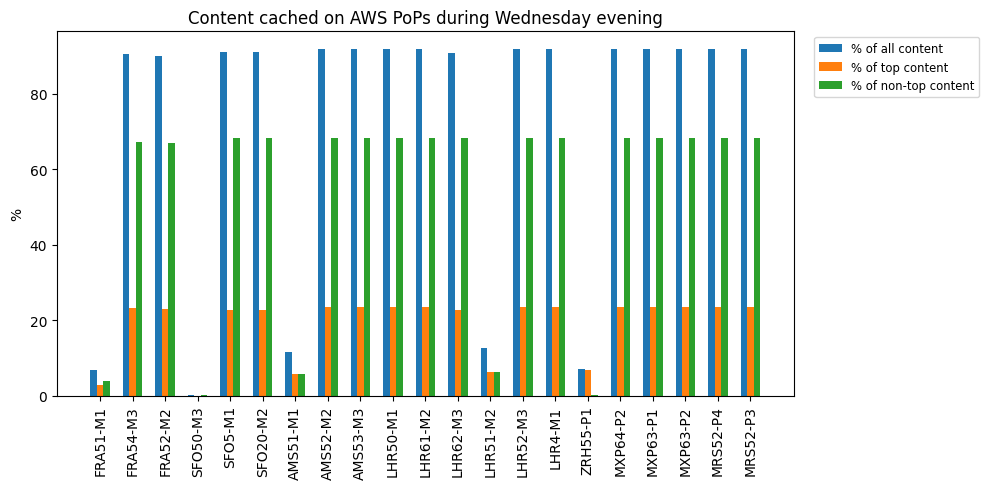

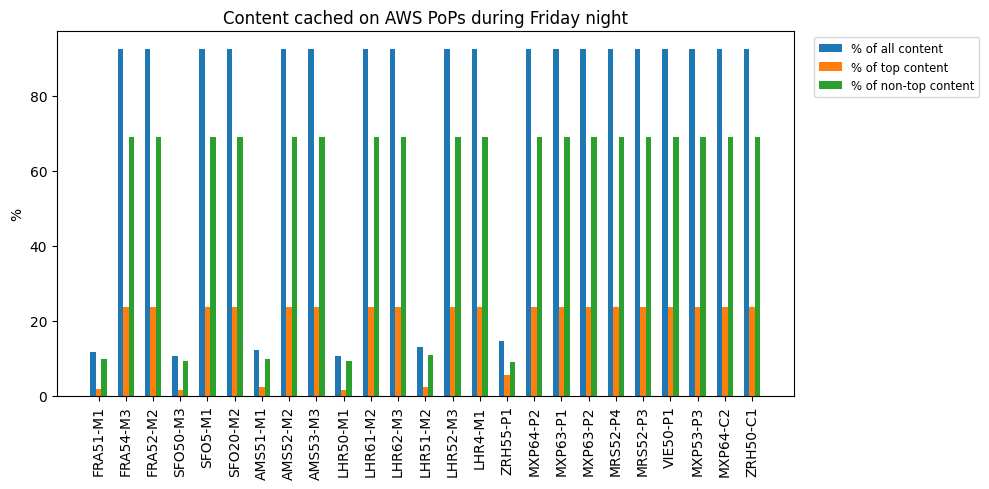

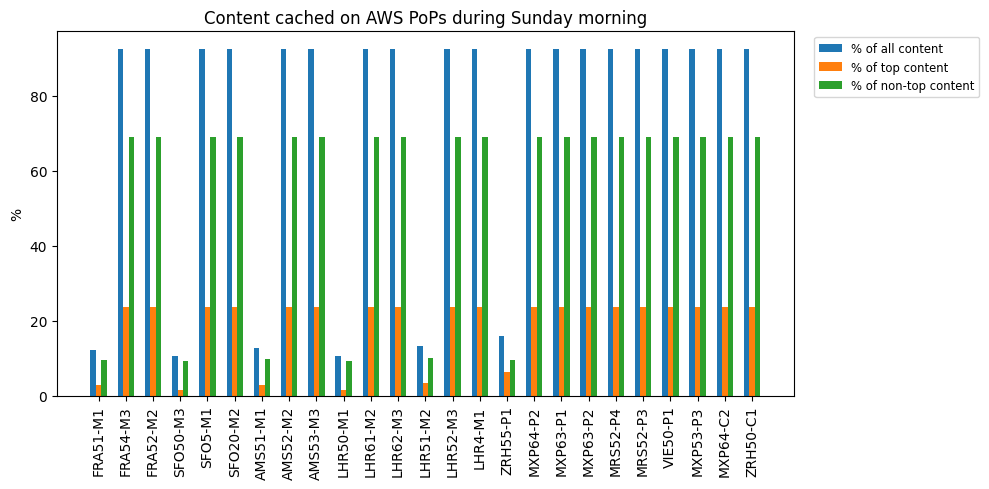

In [572]:
### SNAPSHOTS
# Load data into dfs
RESULT_SNAPSHOT_PATH = "./snapshots/"
for root, dirs, files in os.walk(RESULT_SNAPSHOT_PATH):
        # root: Current directory being scanned
        # dirs: Directories inside the current directory
        # files: Files inside the current directory
        nonpeaktime_df = pd.DataFrame()
        nighttime_df = pd.DataFrame()
        afterweekend_df = pd.DataFrame()
        for i, file in enumerate(files):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            if "nonpeaktime" in file and ".csv" in file:
                nonpeaktime_df = df
                print(f"adding {file} in nonpeaktime_df")
            elif "night_time" in file and ".csv" in file:
                nighttime_df = df
                print(f"adding {file} in nighttime_df")
            elif "nonpeaksunday" in file and ".csv" in file:
                 afterweekend_df = df
                 print(f"adding {file} in afterweekend_df")


# needed to filter top10 content
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv"
        top_content_list.append(line)


dfs = [nonpeaktime_df, nighttime_df, afterweekend_df]
titles = ["Wednesday evening", "Friday night", "Sunday morning"]
for i, df in enumerate(dfs):
    columns = df.columns[1:]

    # Convert the column data to integers
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(int)

    # Initialize lists to store the results
    total_ones = []
    ones_top10 = []
    ones_unpopular = []

    for column in columns:
        # Get the total number of 1s
        total_ones.append(df[column].sum()/10)
        
        # Get the number of 1s from content containing "top"
        ones_top10.append(df[df['content'].str.contains('_top_')][column].sum()/10)
        
        # Get the number of 1s from content not containing "top"
        ones_unpopular.append(df[~df['content'].str.contains('_top_')][column].sum()/10)


    # Plotting the results
    x = range(len(columns))
    labels = ['% of all content', '% of top content', '% of non-top content']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.bar(x, total_ones, width, color=colors[0], label=labels[0])
    ax.bar([i + width for i in x], ones_top10, width, color=colors[1], label=labels[1])
    ax.bar([i + 2*width for i in x], ones_unpopular, width, color=colors[2], label=labels[2])

    #ax.set_xlabel('Columns')
    ax.set_ylabel('%')
    title = titles[i]
    ax.set_title(f'Content cached on AWS PoPs during {title}')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(columns, rotation='vertical')
    #ax.legend()
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    plt.tight_layout()

    # Save the plot with higher resolution (optional)
    plt.savefig(f'./figs/snapshot_{titles[i].lower().replace(" ","_")}.png', dpi=300)

    plt.show() 


adding 0_snapshot_21-06-2023_18hh_04mm-nonpeaktime.csv in nonpeaktime_df
adding 0_snapshot_25-06-2023_12hh_15mm-nonpeaksunday.csv in afterweekend_df
adding 0_snapshot_22-06-2023_23hh_55mm-night_time.csv in nighttime_df


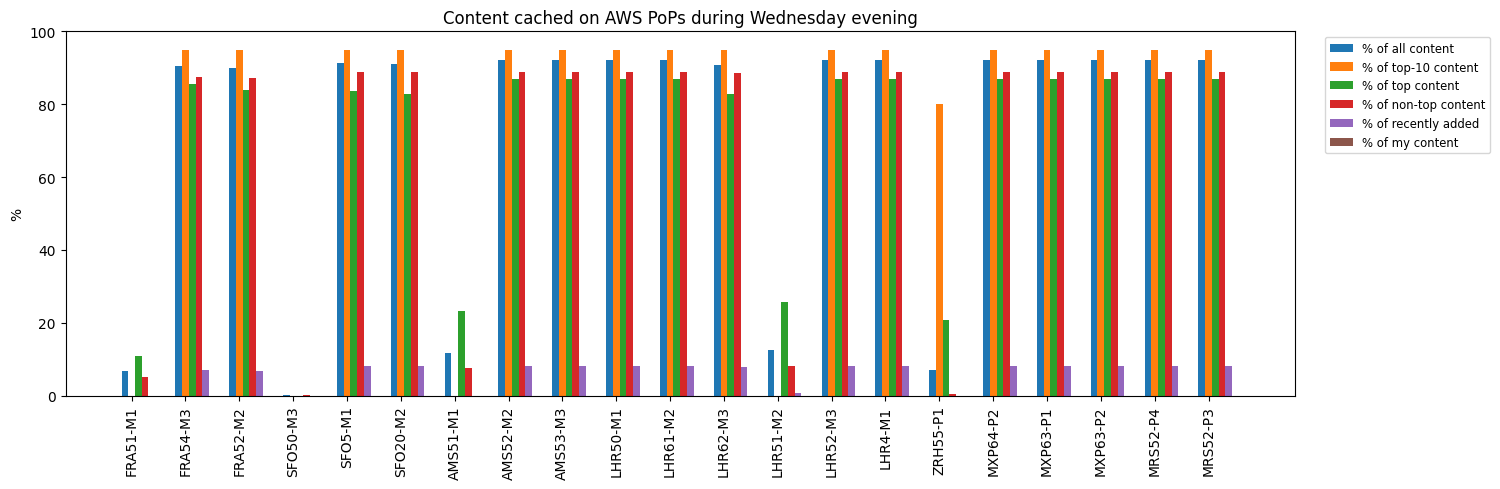

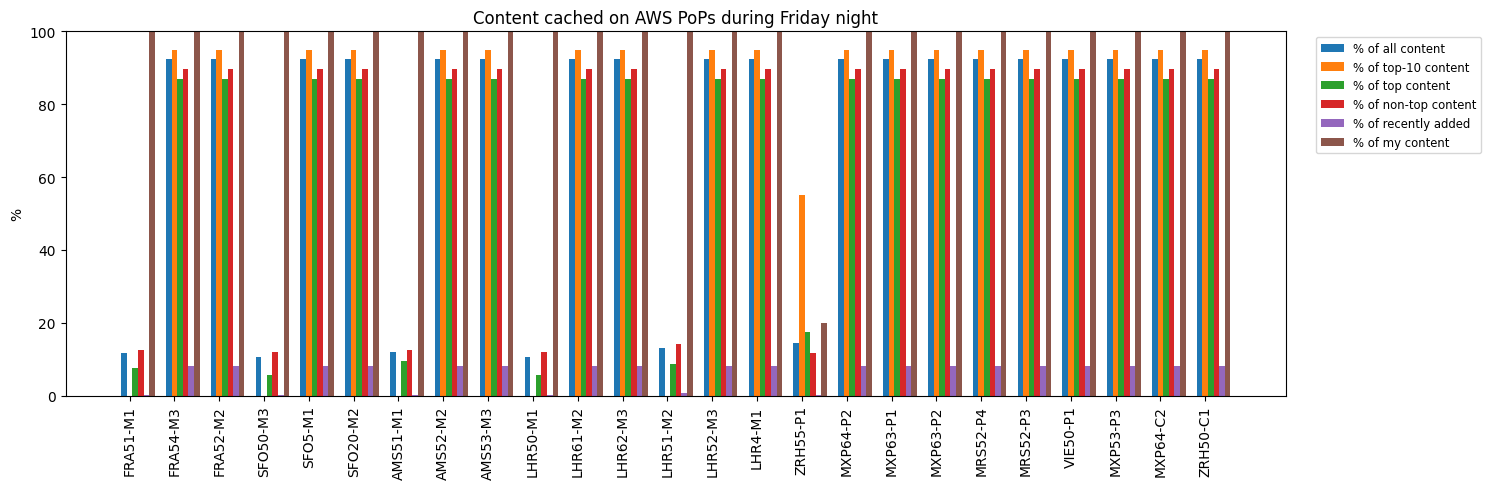

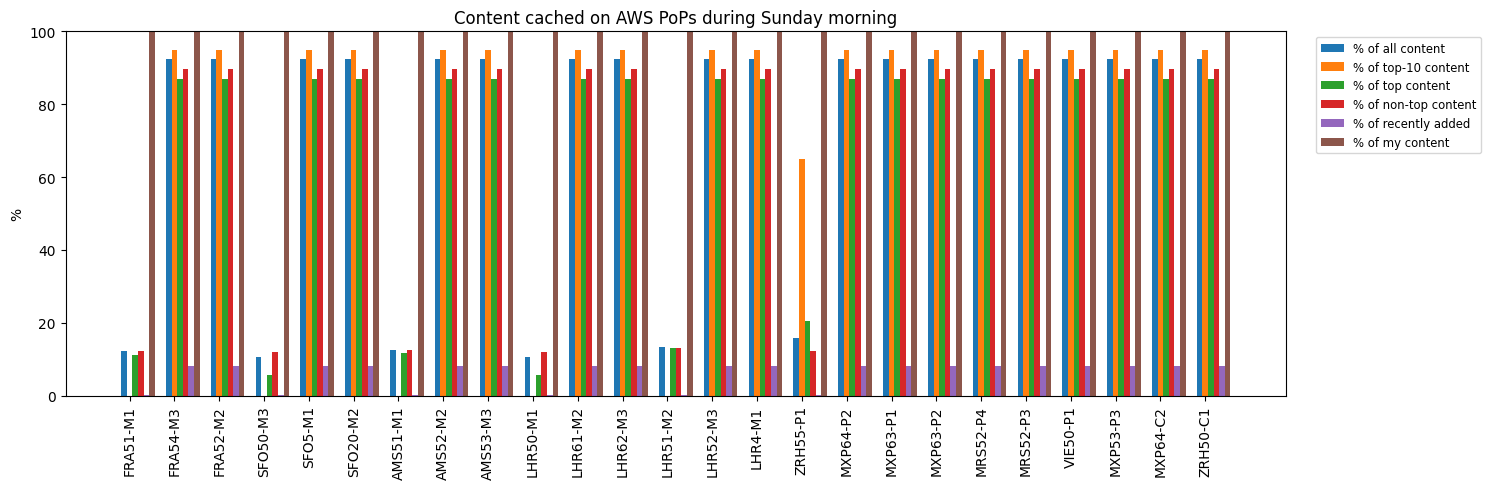

In [700]:
### SNAPSHOTS
# Load data into dfs
RESULT_SNAPSHOT_PATH = "./snapshots/"
for root, dirs, files in os.walk(RESULT_SNAPSHOT_PATH):
        # root: Current directory being scanned
        # dirs: Directories inside the current directory
        # files: Files inside the current directory
        nonpeaktime_df = pd.DataFrame()
        nighttime_df = pd.DataFrame()
        afterweekend_df = pd.DataFrame()
        for i, file in enumerate(files):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            if "nonpeaktime" in file and ".csv" in file:
                nonpeaktime_df = df
                print(f"adding {file} in nonpeaktime_df")
            elif "night_time" in file and ".csv" in file:
                nighttime_df = df
                print(f"adding {file} in nighttime_df")
            elif "nonpeaksunday" in file and ".csv" in file:
                 afterweekend_df = df
                 print(f"adding {file} in afterweekend_df")


# needed to filter top10 content
top_content_list = []
with open("top_content_movies.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_movies"
        top_content_list.append(line)
with open("top_content_tv.txt", 'r') as f:
    for line in f:
        line = line.strip() + "_url_top_tv"
        top_content_list.append(line)


dfs = [nonpeaktime_df, nighttime_df, afterweekend_df]
titles = ["Wednesday evening", "Friday night", "Sunday morning"]
for i, df in enumerate(dfs):
    columns = df.columns[1:]

    # Convert the column data to integers
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(int)

    # Initialize lists to store the results
    total_ones = []
    ones_top10 = []
    ones_popular = []
    ones_unpopular = []
    ones_recentlyadded = []
    ones_mycontent = []

    for column in columns:
        # Get the total number of 1s
        total_ones.append(df[column].sum()/10)
        
        # Get the number of 1s from content containing "top-10"
        ones_top10.append(df[df['content'].isin(top_content_list)][column].sum()*5)

        # Get the number of 1s from content containing "top"
        popular_df = df[df['content'].str.contains('_top_')]
        popular_df = popular_df[~popular_df['content'].isin(top_content_list)]
        ones_popular.append(popular_df[column].sum()*0.4)
        
        # Get the number of 1s from content not containing "top"
        ones_unpopular.append(df[~df['content'].str.contains('_top_')][column].sum()*0.13)

        # Get the number of 1s from content containing "recently added"
        recentlyadded_df = df[df['content'].str.contains('_recentlyadded_')]
        ones_recentlyadded.append(recentlyadded_df[column].sum()/10)

        # Get the number of 1s from content containing "recently added"
        mycontent_df = df[df['content'].str.contains('myvideo')]
        ones_mycontent.append(mycontent_df[column].sum()*20)

    # Plotting the results
    x = range(len(columns))
    labels = ['% of all content', '% of top-10 content', '% of top content', '% of non-top content', '% of recently added', '% of my content']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#8c914d'] 


    width = 0.125

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.bar(x, total_ones, width, color=colors[0], label=labels[0])
    ax.bar([i + width for i in x], ones_top10, width, color=colors[1], label=labels[1])
    ax.bar([i + 2*width for i in x], ones_popular, width, color=colors[2], label=labels[2])
    ax.bar([i + 3*width for i in x], ones_unpopular, width, color=colors[3], label=labels[3])
    ax.bar([i + 4*width for i in x], ones_recentlyadded, width, color=colors[4], label=labels[4])
    ax.bar([i + 5*width for i in x], ones_mycontent, width, color=colors[5], label=labels[5])

    #ax.set_xlabel('Columns')
    ax.set_ylabel('%')
    title = titles[i]
    ax.set_title(f'Content cached on AWS PoPs during {title}')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(columns, rotation='vertical')
    #ax.legend()
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    plt.tight_layout()

    # Set y-axis limit to 100
    ax.set_ylim([0, 100])


    # Save the plot with higher resolution (optional)
    plt.savefig(f'./figs/xsnapshot_{titles[i].lower().replace(" ","_")}.png', dpi=300)

    plt.show() 
